In [1]:
import cv2
import os
import numpy as np

def load_images_from_folders(base_folder):
    images = []
    image_paths = []
    for label in os.listdir(base_folder):
        # if label == 'B' or label == 'C' or label == 'D':
        folder_path = os.path.join(base_folder, label)
        for filename in os.listdir(folder_path):
            if filename[2] == '1':
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (64, 64))
                    # _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
                    images.append(img)
                    image_paths.append(img_path)
    return images, image_paths

folder = 'E:/Data/JHA/CASIA_char_imgs/Gnttest'
images, image_paths = load_images_from_folders(folder)
print(f"Loaded {len(images)} images")


Loaded 4000 images


In [2]:
sift = cv2.SIFT_create()

def extract_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

descriptors_list = []
for image in images:
    descriptors = extract_features(image)
    if descriptors is not None:
        descriptors_list.append(descriptors)

# 假设你的 descriptors_list 已经有数据
def pad_descriptors(descriptors_list):
    # 1. 找出最大的行数
    max_rows = max([desc.shape[0] for desc in descriptors_list])
    
    # 2. 对每个数组进行补全
    padded_descriptors = []
    for desc in descriptors_list:
        # 获取当前数组的行数和列数
        rows, cols = desc.shape
        # 创建一个全为 0 的数组，大小为 (max_rows, cols)
        padded_desc = np.zeros((max_rows, cols))
        # 将原始数组填入前面部分
        padded_desc[:rows, :] = desc
        # 添加到补全后的列表中
        padded_desc = np.reshape(padded_desc, (1, -1)).squeeze()
        padded_descriptors.append(padded_desc)
    return padded_descriptors

# 使用方法
padded_descriptors_list = pad_descriptors(descriptors_list)

print(f"Extracted descriptors for {len(descriptors_list)} images")


Extracted descriptors for 4000 images


Feature matrix shape: (4000, 15744)


e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
e:\Anaconda\envs\jha\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


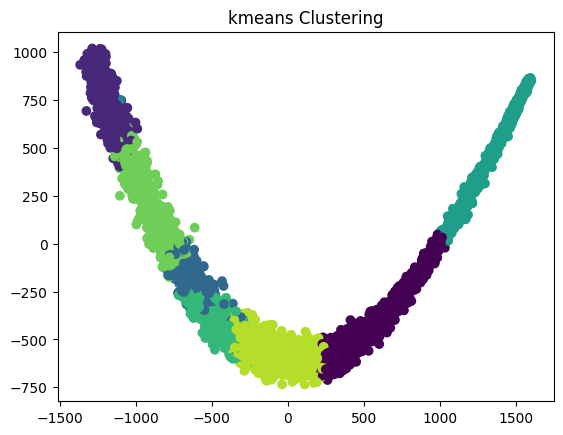

In [5]:
from sklearn.cluster import MiniBatchKMeans

# 将BoVW特征向量堆叠成一个大的数组

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


X = np.array(padded_descriptors_list)
print(f"Feature matrix shape: {X.shape}")

# 使用K-Means进行图像聚类
image_kmeans = MiniBatchKMeans(n_clusters=10, random_state=0).fit(X)
image_labels = image_kmeans.labels_

pca = PCA(n_components=2) 
X = pca.fit_transform(X)

# 绘制聚类结果
plt.scatter(X[:, 0], X[:, 1], c=image_labels, cmap='viridis')

plt.title('kmeans Clustering')
plt.show()

In [6]:
print(image_paths.__len__())

4000


In [7]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
import os

# 1. 提取真实标签
# 使用 os.path 来处理路径，确保兼容性
true_labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
print(f"提取的真实标签（unique）：{set(true_labels)}")

# 2. 标签编码
# 创建真实标签到索引的映射
label_to_index = {label: idx for idx, label in enumerate(sorted(set(true_labels)))}
print(f"真实标签到索引的映射：{label_to_index}")

true_labels_encoded = np.array([label_to_index[label] for label in true_labels])
print(f"编码后的真实标签：{true_labels_encoded}")

# 将聚类标签编码为整数（如果尚未编码）
cluster_labels = np.array(image_labels)
unique_cluster_labels = np.unique(cluster_labels)
cluster_label_to_index = {label: idx for idx, label in enumerate(sorted(unique_cluster_labels))}
print(f"聚类标签到索引的映射：{cluster_label_to_index}")

cluster_labels_encoded = np.array([cluster_label_to_index[label] for label in cluster_labels])
print(f"编码后的聚类标签：{cluster_labels_encoded}")

# 3. 计算混淆矩阵
# 使用最大标签索引 + 1 来确保矩阵大小足够
num_classes = max(true_labels_encoded.max(), cluster_labels_encoded.max()) + 1
print(f"类别总数：{num_classes}")

confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
print(f"混淆矩阵的形状：{confusion_matrix.shape}")

for true_label, cluster_label in zip(true_labels_encoded, cluster_labels_encoded):
    confusion_matrix[true_label][cluster_label] += 1

# 4. 使用线性分配算法找到最佳匹配
row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

# 创建聚类标签到真实标签的映射
cluster_to_true_label = dict()
for cluster_label, true_label in zip(col_ind, row_ind):
    cluster_to_true_label[cluster_label] = true_label

# 5. 重新映射聚类标签并计算准确率
mapped_cluster_labels = [cluster_to_true_label[label] for label in cluster_labels_encoded]
accuracy = accuracy_score(true_labels_encoded, mapped_cluster_labels)

print(f"聚类准确率为: {accuracy * 100:.2f}%")


提取的真实标签（unique）：{'062-t', '038-t', '029-t', '006-t', '042-t', '058-t', '060-t', '046-t', '020-t', '013-t'}
真实标签到索引的映射：{'006-t': 0, '013-t': 1, '020-t': 2, '029-t': 3, '038-t': 4, '042-t': 5, '046-t': 6, '058-t': 7, '060-t': 8, '062-t': 9}
编码后的真实标签：[0 0 0 ... 9 9 9]
聚类标签到索引的映射：{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
编码后的聚类标签：[5 5 5 ... 0 0 8]
类别总数：10
混淆矩阵的形状：(10, 10)
聚类准确率为: 14.03%


Cluster 0


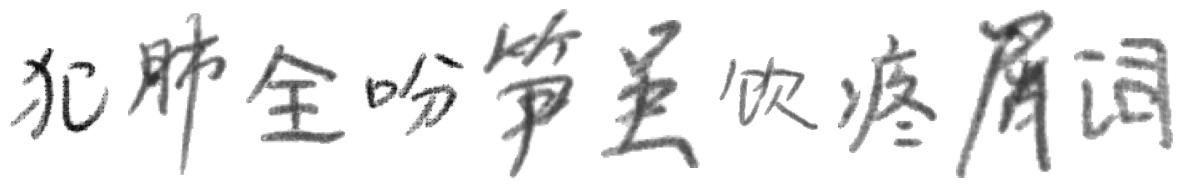

Cluster 1


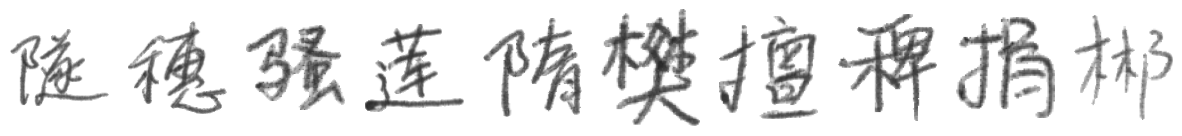

Cluster 2


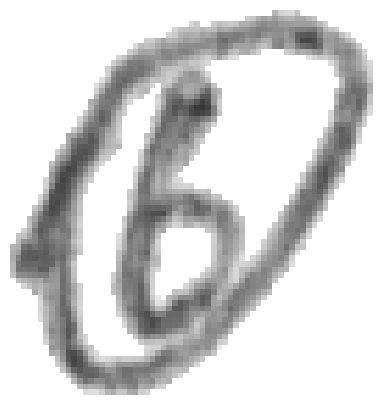

Cluster 3


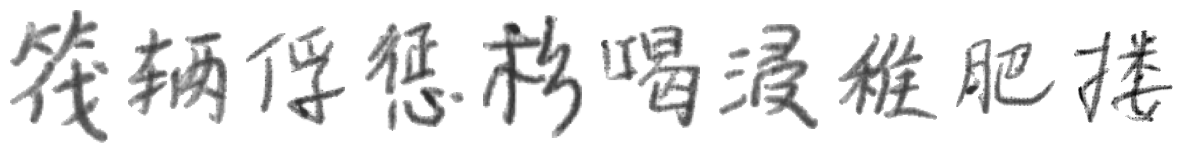

Cluster 4


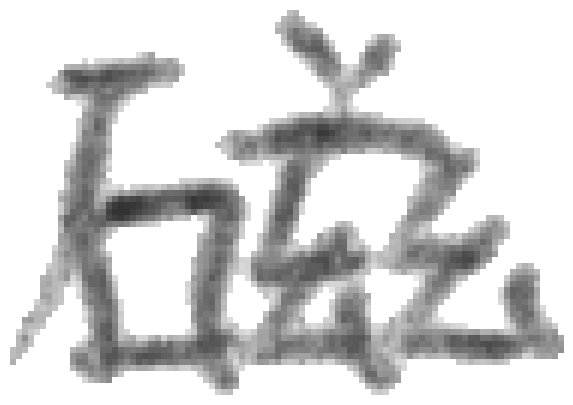

Cluster 5


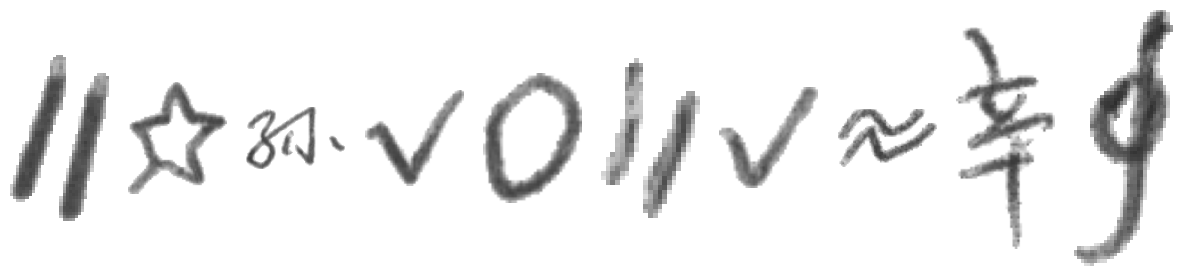

Cluster 6


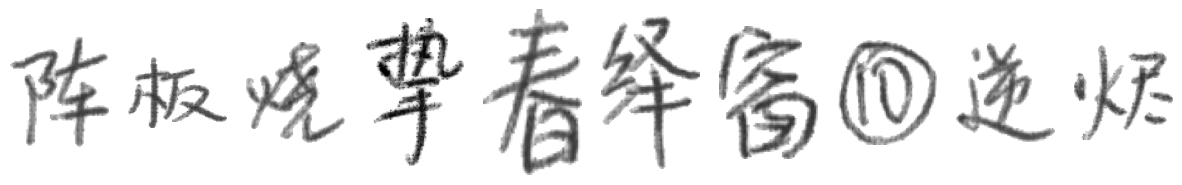

Cluster 7


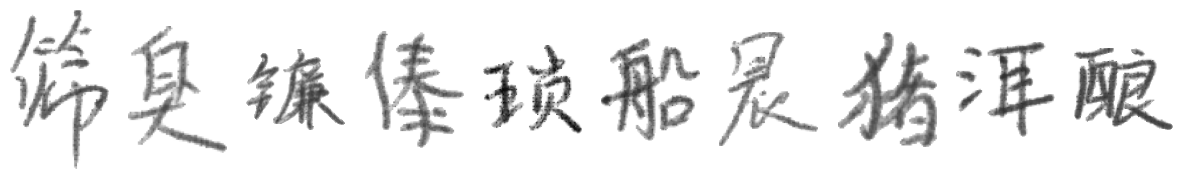

Cluster 8


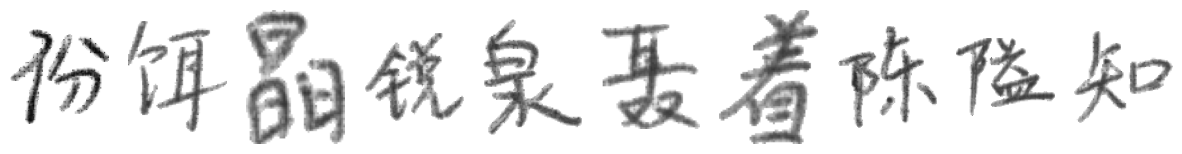

Cluster 9


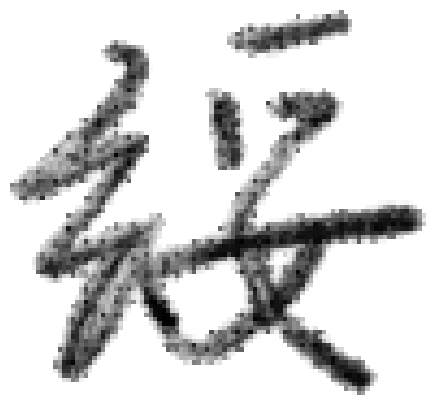

In [9]:
import matplotlib.pyplot as plt
import random

def plot_images_by_cluster(image_paths, labels, cluster_id):
    cluster_images = [img_path for img_path, label in zip(image_paths, labels) if label == cluster_id]
    num_images = min(len(cluster_images), 10)  # 每个聚类显示最多10张图片
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(cluster_images, num_images)):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# 显示每个聚类中的图像
for cluster_id in range(10):
    print(f"Cluster {cluster_id}")
    plot_images_by_cluster(image_paths, image_labels, cluster_id)
